# <center/> Курсовая работа </center>
# <center/> Сегментация спутниковых изображений, распознование лесов </center>

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim
import torch.nn.functional as F
from glob import glob
import csv
import random
import re
import os
from PIL import Image
import numpy as np
import sklearn.metrics
import matplotlib
import cv2

### Для сегментации будет использована архитектура U-net

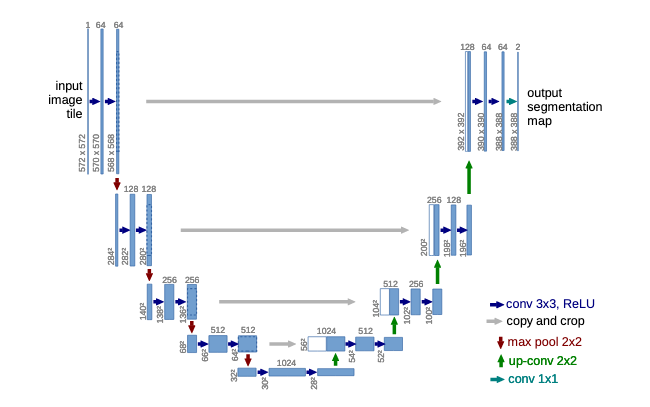

In [4]:
from IPython import display
display.Image(filename= "/content/drive/MyDrive/Forest_Image_Segmentation/unet.png")

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as t_f

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=2, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = t_f.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    print(x.shape)
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


In [7]:

data_transform = transforms.Compose([
        #transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
class image_seg(Dataset):
    def __init__(self, data_dir='' ,transform=data_transform):
        self.transform = data_transform
        self.dirs =glob(data_dir)
    def __len__(self):
        return len(self.dirs)
    def __getitem__(self, idx):
        input = Image.open(self.dirs[idx])
        filename = os.path.basename(self.dirs[idx])
        common_dir = os.path.dirname(os.path.dirname(self.dirs[idx]))
        label_dir = common_dir +'/masks/'+filename[:-4] + 'png'
        label = Image.open(label_dir).convert('L')

        input = input.resize((412,412), Image.LINEAR)
        input = np.array(input).transpose(2,0,1)
        label = label.resize((412,412), Image.NEAREST)
        label = np.array(label)

        #input = self.transform(input)
        #input = torch.from_numpy(np.array(input)[:,0:224,0:224]).float()
        #label = np.array(label)[0:224,0:224]
        label[label==255] = 1
        label = torch.from_numpy(label).long()

        input = torch.from_numpy(input).float()
        return input, label

Dataset_obj_train = image_seg(data_dir ='drive/My Drive/Forest_Image_Segmentation/Amazon_Forest_Dataset/Training/images/**.tiff' ,transform=data_transform)
trainloader = DataLoader(Dataset_obj_train, batch_size=1,shuffle=True)

Dataset_obj_valid = image_seg(data_dir ='drive/My Drive/Forest_Image_Segmentation/Amazon_Forest_Dataset/Validation/images/**.tiff',transform=data_transform)
validloader = DataLoader(Dataset_obj_valid, batch_size=1,shuffle=False)

In [9]:
class image_seg_test(Dataset):
    def __init__(self, data_dir='' ,transform=data_transform):
        self.transform = data_transform
        self.dirs =glob(data_dir)
    def __len__(self):
        return len(self.dirs)
    def __getitem__(self, idx):
        input = Image.open(self.dirs[idx])
        filename = os.path.basename(self.dirs[idx])
        common_dir = os.path.dirname(os.path.dirname(self.dirs[idx]))
        input = input.resize((224,224), Image.LINEAR)
        input = np.array(input).transpose(2,0,1)
        input = torch.from_numpy(input).float()
        return input, filename[:-4]

Dataset_obj_test = image_seg_test(data_dir ='drive/My Drive/Forest_Image_Segmentation/Amazon_Forest_Dataset/Test/**.tiff',transform=data_transform)
testloader = DataLoader(Dataset_obj_test, batch_size=1,shuffle=False)


In [13]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
#device = torch.device('cpu') 
loss_function = torch.nn.CrossEntropyLoss()
net  = UNET()
optimizer = torch.optim.Adam(net.parameters())
net.to(device)
torch.autograd.set_detect_anomaly(False)

best_loss = float('inf')
best_epoch = 0
best_acc = 0
loss_train = []
loss_test = []
for epoch in range(50):
    totoal_loss = 0
    net.train()
    for inputs,labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = net(inputs)
        loss = loss_function(logits,labels)
        totoal_loss += loss.item()

        trgt = labels.cpu().detach().numpy().reshape(-1)
        lbl = logits.argmax(dim=1).cpu().detach().numpy().reshape(-1)
        #jsc = sklearn.metrics.jaccard_similarity_score(trgt, lbl)

        loss.backward()
        optimizer.step()
        

    loss_train.append(totoal_loss/len(trainloader))    

    print (f'Epoch: {epoch+1:02} |Loss:{totoal_loss/len(trainloader)}')
    #print (f'Epoch: {epoch+1:02} |Jaccard Loss:{jsc}')

    net.eval()
    with torch.no_grad():
        for inputs,labels in validloader:
            inputs = inputs.to(device)
            labels = labels.to(device)  
            logits = net(inputs)
            loss = loss_function(logits,labels)
        
        loss_test.append(loss.item())            

        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch
            torch.save(net.state_dict(), 'best_model.pt')
            
        print("curr_val_loss:",loss.item(), "epoch:", epoch+1, "best_loss",best_loss.item(),"best_epoch",best_epoch)

Epoch: 01 |Loss:0.4934531440337499
curr_val_loss: 1.809021234512329 epoch: 1 best_loss 1.809021234512329 best_epoch 0
Epoch: 02 |Loss:0.42713222404321033
curr_val_loss: 2.5997188091278076 epoch: 2 best_loss 1.809021234512329 best_epoch 0
Epoch: 03 |Loss:0.3906402972837289
curr_val_loss: 0.785467267036438 epoch: 3 best_loss 0.785467267036438 best_epoch 2
Epoch: 04 |Loss:0.38609272514780363
curr_val_loss: 2.279231548309326 epoch: 4 best_loss 0.785467267036438 best_epoch 2
Epoch: 05 |Loss:0.3838491941491763
curr_val_loss: 1.4608542919158936 epoch: 5 best_loss 0.785467267036438 best_epoch 2
Epoch: 06 |Loss:0.3251632653176785
curr_val_loss: 0.5430976152420044 epoch: 6 best_loss 0.5430976152420044 best_epoch 5
Epoch: 07 |Loss:0.3164561532437801
curr_val_loss: 0.4011077582836151 epoch: 7 best_loss 0.4011077582836151 best_epoch 6
Epoch: 08 |Loss:0.2969210553914309
curr_val_loss: 1.2033296823501587 epoch: 8 best_loss 0.4011077582836151 best_epoch 6
Epoch: 09 |Loss:0.29682037408153217
curr_val_l

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# График распространения ошибки

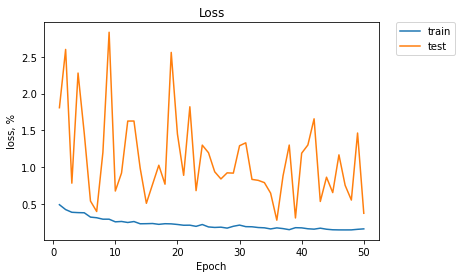

In [14]:
import matplotlib.pyplot as plt
names = ["train", "test"]
loss = [loss_train, loss_test]

for i in range(len(names)):
    plt.plot(range(1, 51), loss[i], label=names[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('loss, %')
plt.title('Loss')

plt.show()

In [27]:
net.load_state_dict(torch.load('best_model.pt'))

total_f1 = 0
total_jaccard = 0
preds = []
ans = []
k = 0

for input,label in validloader:
    input = input.to(device)
    logit = net(input)
    pred = logit.argmax(dim=1)
    preds.append(pred)
    ans.append(label)
    matplotlib.image.imsave('pred' + str(k) +'.png', pred[0].cpu().numpy())
    matplotlib.image.imsave('labels' + str(k) + '.png', label[0].cpu().numpy())
    trgt = label.cpu().detach().numpy().reshape(-1)
    res = logit.argmax(dim=1).cpu().detach().numpy().reshape(-1)
    jsc = sklearn.metrics.jaccard_similarity_score(trgt, res)
    f1 = sklearn.metrics.f1_score(trgt, res)
    total_f1 += f1
    total_jaccard += jsc
    print(f"{k} image: ")
    print("f1-score = ", f1)
    print("jaccard score = ", jsc)
    k += 1

print("Average metrics on valid dataset: \n")
print (f'Jaccard loss : {total_jaccard/len(validloader)} \nFi-score : {total_f1/len(validloader)}')
    
    
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0 image: 
f1-score =  0.7308457941761956
jaccard score =  0.9314968423037044
1 image: 
f1-score =  0.8713090817319825
jaccard score =  0.8317701951173532
2 image: 
f1-score =  0.03324478577628153
jaccard score =  0.7834562635498162
3 image: 
f1-score =  0.04313536807313348
jaccard score =  0.7305295032519559
4 image: 
f1-score =  0.8851906795288949
jaccard score =  0.8349514563106796
5 image: 
f1-score =  0.056921223673934054
jaccard score =  0.5802914977848996
6 image: 
f1-score =  0.4975025506809209
jaccard score =  0.666326939391083
7 image: 
f1-score =  0.0
jaccard score =  0.9856136299368461
8 image: 
f1-score =  0.9936349203994124
jaccard score =  0.9873633235931756
9 image: 
f1-score =  0.7369555314153555
jaccard score =  0.8231100952021868
10 image: 
f1-score =  0.951237735268588
jaccard score =  0.947709491940805
11 image: 
f1-score =  0.611570547532411
jaccard score =  0.4950101329060232
12 image: 
f1-score =  0.2581610127494706
jaccard score =  0.5149578188330662
13 image: 


label                                                                                                         predict


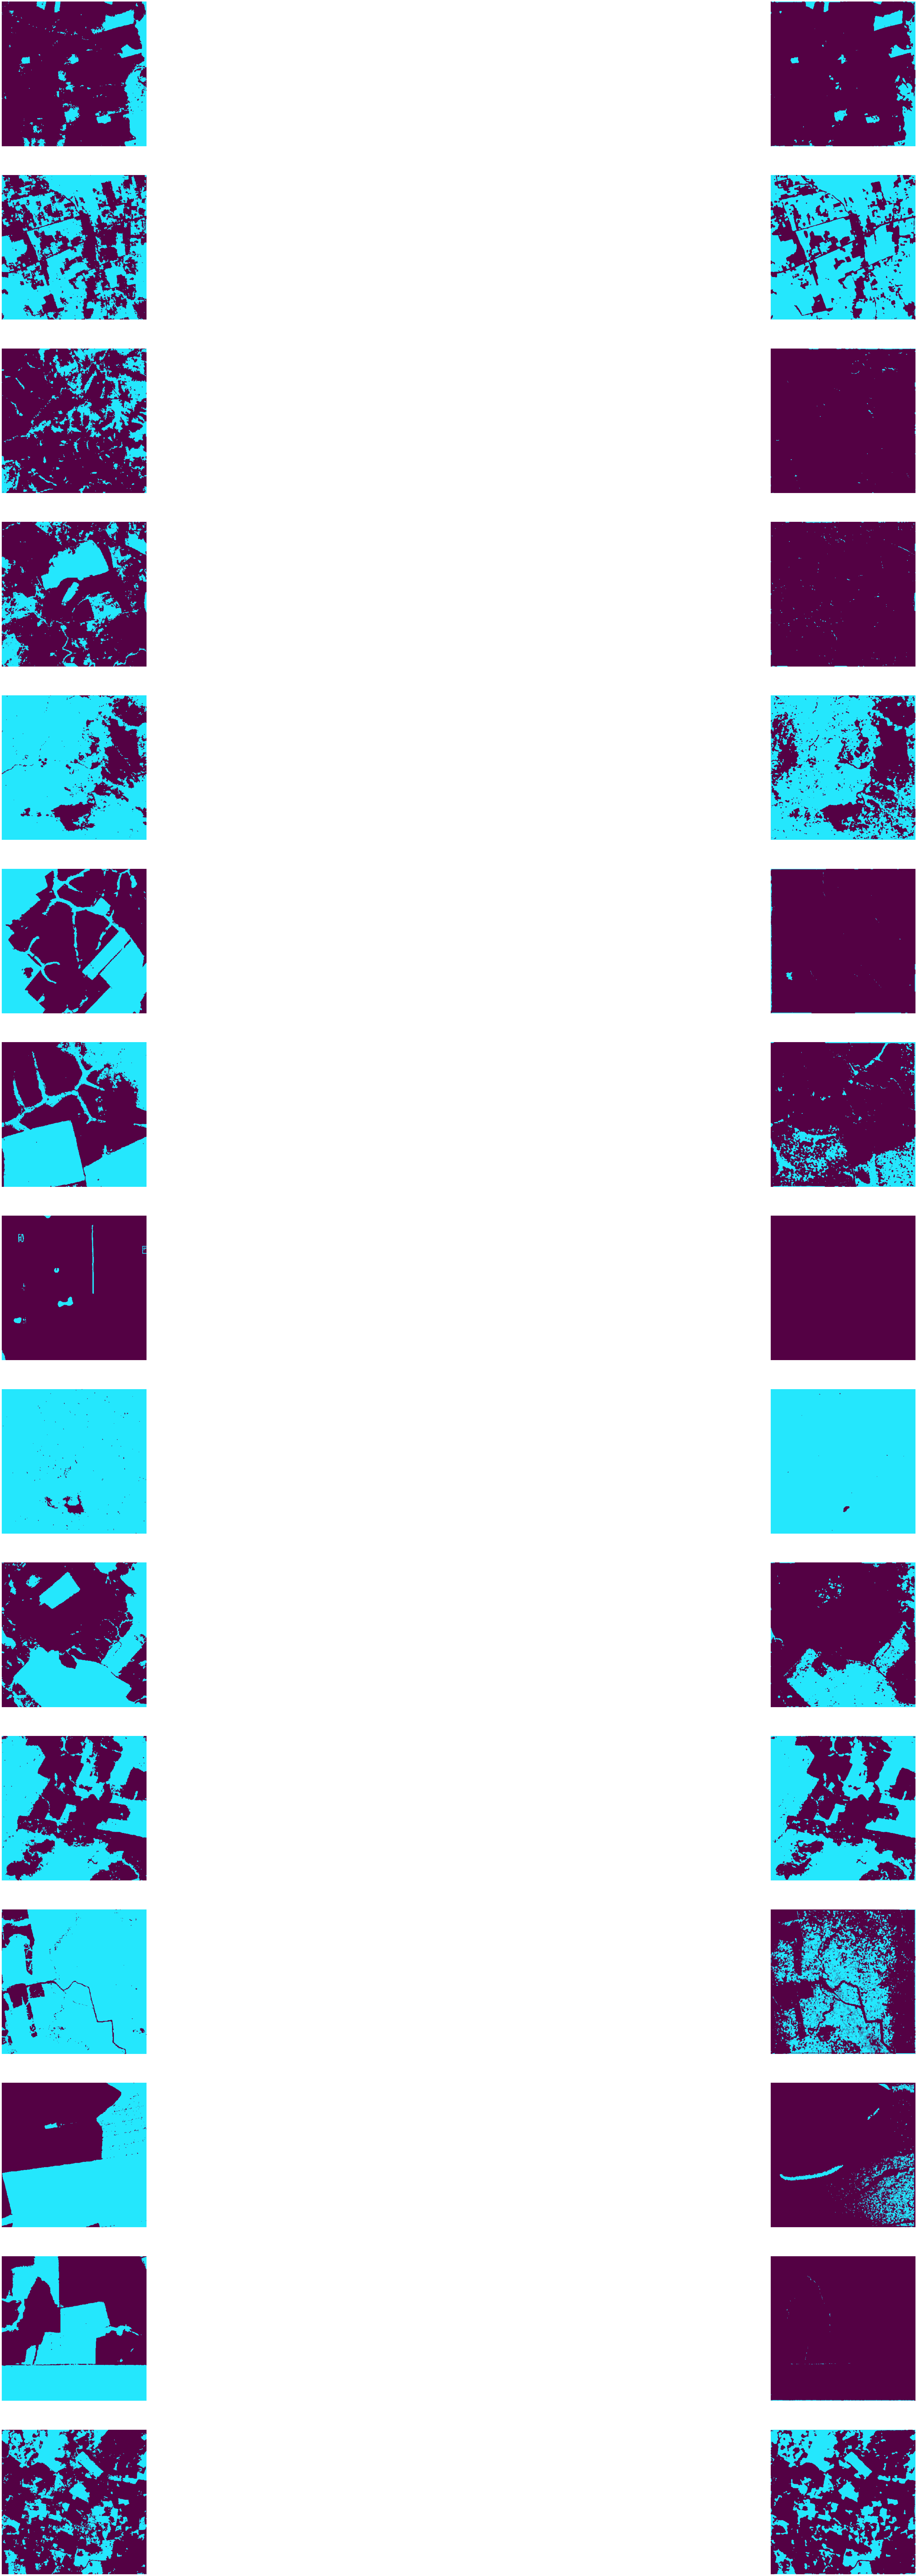

In [20]:
import matplotlib.pyplot as plt

pic_box = plt.figure(figsize=(100, 200))
print("label                                                                                                         predict")

for i in range(len(preds)):
    picture = cv2.imread('/content/labels' + str(i) + '.png')
    pic_box.add_subplot(16,2,i*2 + 1)
    plt.imshow(picture)
    plt.axis('off')
    picture = cv2.imread('/content/pred' + str(i) + '.png')
    pic_box.add_subplot(16, 2, i*2 + 2)
    plt.imshow(picture)
    plt.axis('off')
plt.show() 



In [ ]:
base_dir = 'drive/My Drive/Forest_Image_Segmentation/Amazon_Forest_Dataset/Test_mask'
for inputs,filename_list in testloader:
    inputs = inputs.to(device)
    logit = net(inputs)
    pred = logit.argmax(dim=1)
    for i in range (inputs.size()[0]):
        matplotlib.image.imsave(base_dir+'/'+filename_list[i]+'png', pred[i].cpu().numpy())
    print(filename_list)

('0.',)
('5.',)
('7.',)
('2.',)
('13.',)
('11.',)
('8.',)
('4.',)
('1.',)
('3.',)
('9.',)
('12.',)
('6.',)
('10.',)
('14.',)


In [ ]:
import matplotlib
test_img =glob('drive/My Drive/Forest_Image_Segmentation/Amazon_Forest_Dataset/Test_masks/**.png')
for i in range (len(test_img)):
    test_im = Image.open(test_img[i])
    #print(test_im.size)
    re_testim = test_im.resize((512,512), Image.NEAREST)
    
    #print(re_testim.size)
    matplotlib.image.imsave('drive/My Drive/Forest_Image_Segmentation/Test_masks_orig' + '/'+os.path.basename(test_img[i]), np.array(re_testim))

predict                                                                                                         label

 Test dataset


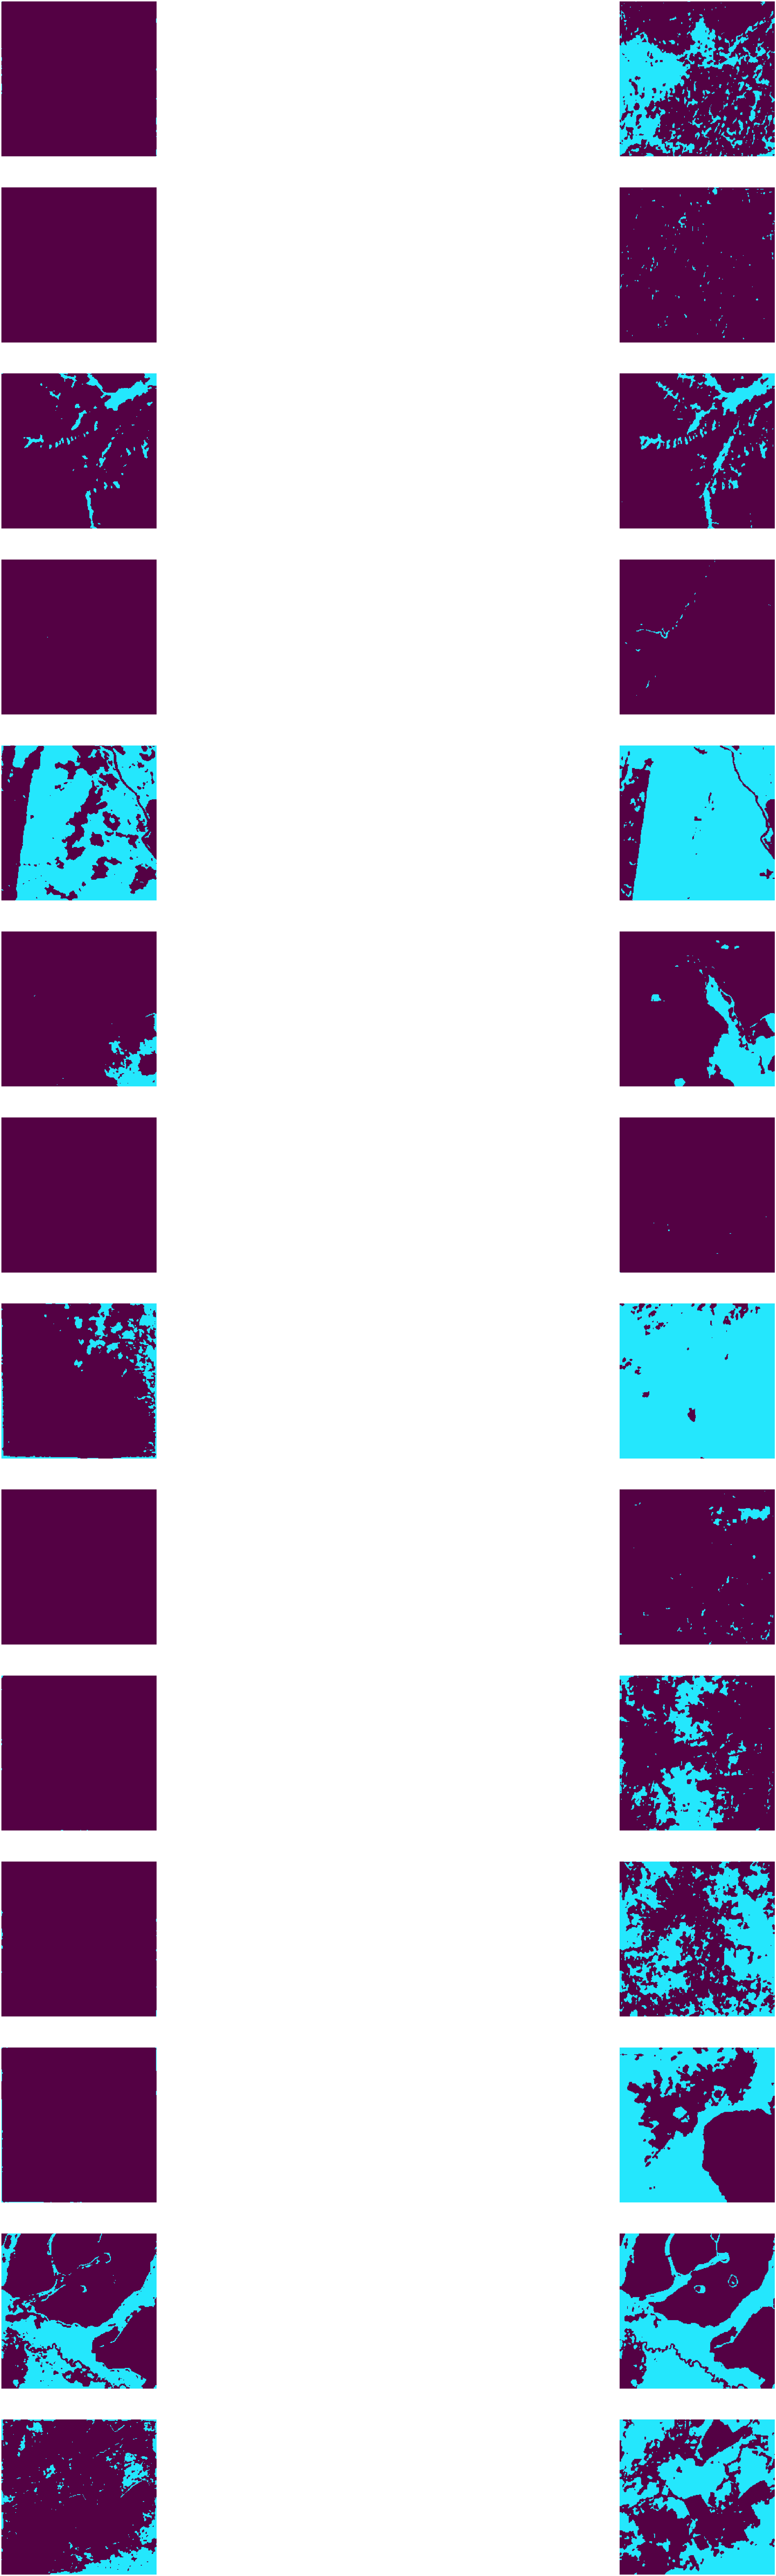

In [ ]:
import matplotlib.pyplot as plt

pic_box = plt.figure(figsize=(100, 250))
print("predict                                                                                                         label")
print("\n Test dataset")
for i in range(1, 15):
    # считываем изображение в picture
    picture = cv2.imread('drive/My Drive/Forest_Image_Segmentation/Amazon_Forest_Dataset/Test_mask/' + str(i) + '.png')
    # конвертируем BGR изображение в RGB
    #picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
    # добавляем ячейку в pix_box для вывода текущего изображения
    pic_box.add_subplot(15,2,(i - 1)*2 + 1)
    plt.imshow(picture)
    # отключаем отображение осей
    plt.axis('off')

    picture = cv2.imread('drive/My Drive/Forest_Image_Segmentation/Test_masks_orig/' + str(i) + '.png')
    pic_box.add_subplot(15, 2, (i - 1)*2 + 2)
    plt.imshow(picture)
    plt.axis('off')
# выводим все созданные фигуры на экран
plt.show() 